# From Parchment to Screen: An Analysis of Medieval Aesthetics in Opening Sequence

This Jupiter Notebook is part of a master's thesis that explores the aesthetics of title cards from opening title sequences of films set in the European Middle Ages.

The research involved the development of a JSON-LD database containing production information about each movie along with the title card images. The notebook provides a visualization of key information from the database, making it easier to read and comprehend. Different graphs and charts have been selected to show the variety of data presentation options.

Each section contains code and a brief description of how it works, in addition to a plot (in other words, a graphical representation of data).

- Data format: JSON-LD database 
- Data creation process: The movies for the database were released between 1901 and 1964. The source was the list on [Letterboxd](https://letterboxd.com/nanshe_of_nina/list/medieval/) and “The Reel Middle Ages” by Kevin J. Harty. The methodology for including the films in the database is described in the thesis of which this Notebook is a part of.
- Data source: [Github](https://github.com/chmsv/An-Analysis-of-Medieval-Aesthetics-in-Opening-Sequence/blob/main/source/Medieval_Movies.jsonld)
- [Master's thesis website](https://chmsv.github.io/Analysis-of-Medieval-Aesthetics-in-Opening-Sequence/)

## Table of contents

1. [Data Loading and Preprocessing](#Data-Loading-and-Preprocessing)
2. [Basic Exploration](#Basic-Exploration)
    1. [Films by Year and Top 5 Directors](#Films-by-Year-and-Top-5-Directors)
3. [More Complex Plots](#More-Complex-Plots)
    1. [Temporal Coverage Analysis](#Temporal-Coverage-Analysis)
    2. [Geospatial Analysis of Production Countries](#Geospatial-Analysis-of-Production-Countries)
    3. [Geospartial Analysis of Countries Depicted in Films](#Geospartial-Analysis-of-Countries-Depicted-in-Films)
    4. [Complex Multi-dimensional Analysis](#Complex-Multi-dimensional-Analysis)
    5. [Word Cloud](#Word-Cloud)
    6. [Heatmap](#Heatmap)
    7. [Keywords Frequency](#Keywords-Frequency)
    8. [Evolution of Color and Sound](#Evolution-of-Color-and-Sound)

## Data Loading and Preprocessing

First of all, import the basic libraries to work with the database. Then open and read the file and check it for errors.

The main libraries are:
- json is for handling .jsonld file.
- pandas is a popular data manipulation library for Python.

In [1]:
# Import main libraries
import json
import pandas as pd

# Open and read a database file
with open('Medieval_Movies.jsonld', 'r') as file:
    data = json.load(file)

movies = data.get('@graph', data)

df = pd.DataFrame(movies)

df = pd.json_normalize(movies)

## Basic Exploration

Here are the simplest visualizations of the data. The first *graph* is a timeline with the number of movies released in each year. The second is the top five directors. The *pie chart* demonstrates the division by genre in the database.

Additional libraries had to be imported to create these graphs. These are:
- matplotlib is used for figure creation and basic plot settings.
- seaborn provides higher-level plotting functions for bar charts creating.

### Films by Year and Top 5 Directors

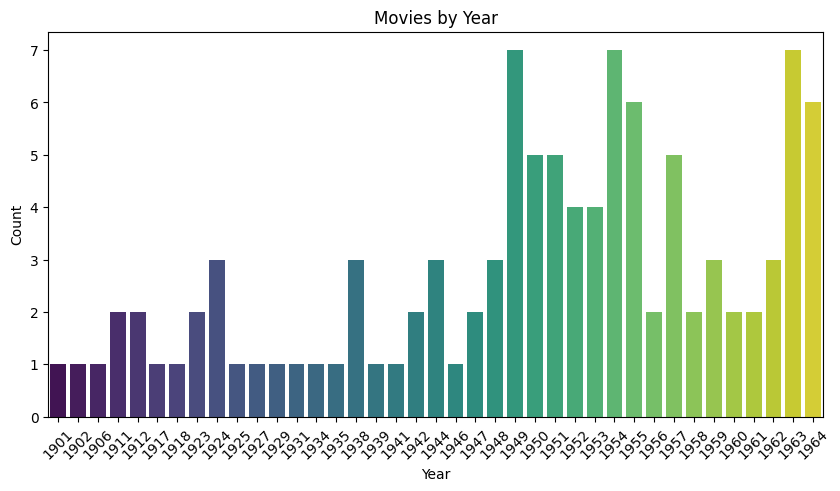

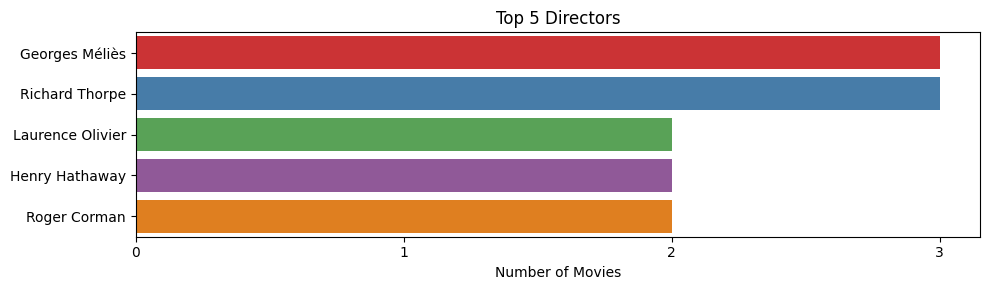

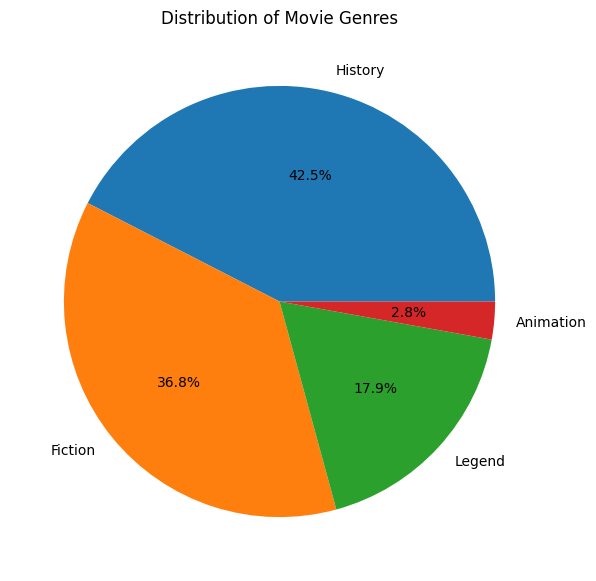

In [2]:
# Import additional libraries for data visualization
import seaborn as sns
import matplotlib.pyplot as plt

#Films by Year
plt.figure(figsize=(10, 5))
df['datePublished'] = pd.to_datetime(df['datePublished'])
year_counts = df['datePublished'].dt.year.value_counts().sort_index()
sns.barplot(x=year_counts.index, y=year_counts.values, palette='viridis')

plt.title('Movies by Year')
plt.xlabel('Year')
plt.ylabel('Count')

plt.xticks(rotation=45)
plt.show()

#Top 5 Directors
plt.figure(figsize=(10, 3))

director_counts = df['director'].explode().apply(lambda x: x['name'] if isinstance(x, dict) else x).value_counts()

top_5_directors = director_counts.head(5)

sns.barplot(x=top_5_directors.values, y=top_5_directors.index, palette='Set1')

plt.title('Top 5 Directors')
plt.xlabel('Number of Movies')
plt.xticks(range(0, int(top_5_directors.max()) + 1))

plt.tight_layout()
plt.show()

#Genre Analysis
genre_counts = df['genre'].explode().value_counts()

plt.figure(figsize=(10, 7))
plt.pie(genre_counts, labels=genre_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Movie Genres')
plt.show()

## More Complex Plots

The following are more advanced visualizations that allow you to build complex relationships between items in the dataset and trace dependencies.

### Temporal Coverage Analysis

To display a *bar chart* listing the centuries in which the films are set, it was necessary to import another library with a collection of mathematical functions - numpy (Numerical Python). 

Here, np.linspace(0, 1, len(unique_centuries)) generates a sequence of evenly spaced numbers between 0 and 1. The number of points is equal to the number of periods. This array is used to create a color gradient using Matplotlib's viridis colormap.

In addition to the graph, a list with the number of films by century is available in a simple text format. The main difference, besides the lack of visualization, is the inclusion of the films set in the Middle Ages but without specifying a period.

More details about how I determined the chronological boundaries are written in the thesis.

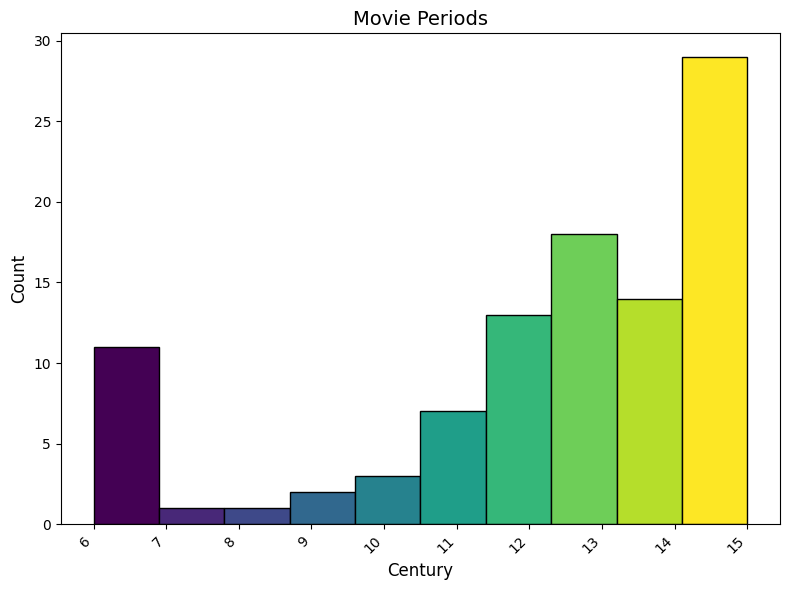

Movies by century:
6th: 11
7th: 1
8th: 1
9th: 2
10th: 3
11th: 7
12th: 13
13th: 18
14th: 14
15th: 29
unknown: 7


In [3]:
# Import an additional library for data visualization
import numpy as np

# Convert temporalCoverage property to centuries
df['century'] = df['temporalCoverage'].str.extract('(\d+)').astype(float)
unique_centuries = sorted(df['century'].dropna().unique())

plt.figure(figsize=(8, 6))

# Create a colormap and a histogram
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_centuries)))
n, bins, patches = plt.hist(df['century'].dropna(), bins=len(unique_centuries), edgecolor='black')


for patch, color in zip(patches, colors):
    patch.set_facecolor(color)

plt.title('Movie Periods', fontsize=14)
plt.xlabel('Century', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.xticks(unique_centuries)

plt.xticks(rotation=45, ha='right')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{int(x)}"))
plt.tight_layout()

plt.show()

# Legend description
century_counts = df['temporalCoverage'].value_counts()
century_order = ['6th', '7th', '8th', '9th', '10th', '11th', '12th', '13th', '14th', '15th', 'undefined']

print("Movies by century:")
for century in century_order:
    if century in century_counts:
        if century == 'undefined':
            print(f"unknown: {century_counts[century]}")
        else:
            print(f"{century}: {century_counts[century]}")
    else:
        print(f"{century}: 0")

### Geospatial Analysis of Production Countries

Another library added is geopandas. It extends the capabilities of pandas to handle geographic data.

This visualization presents geographic analysis of film production countries. Besides the database it includes a shapefile (.shp), a popular vector data format with geographical data. It was downloaded from a website with collections of open-source public datasets named [Natural Earth](https://www.naturalearthdata.com/downloads/110m-cultural-vectors/). 

Basically, this code creates a *choropleth map* showing the number of films produced in Western countries (Europe and USA regions), with darker colors indicating higher counts. The code matches countries from the database (specified in the "countryOfOrigin" property) with country names from the .shp file.

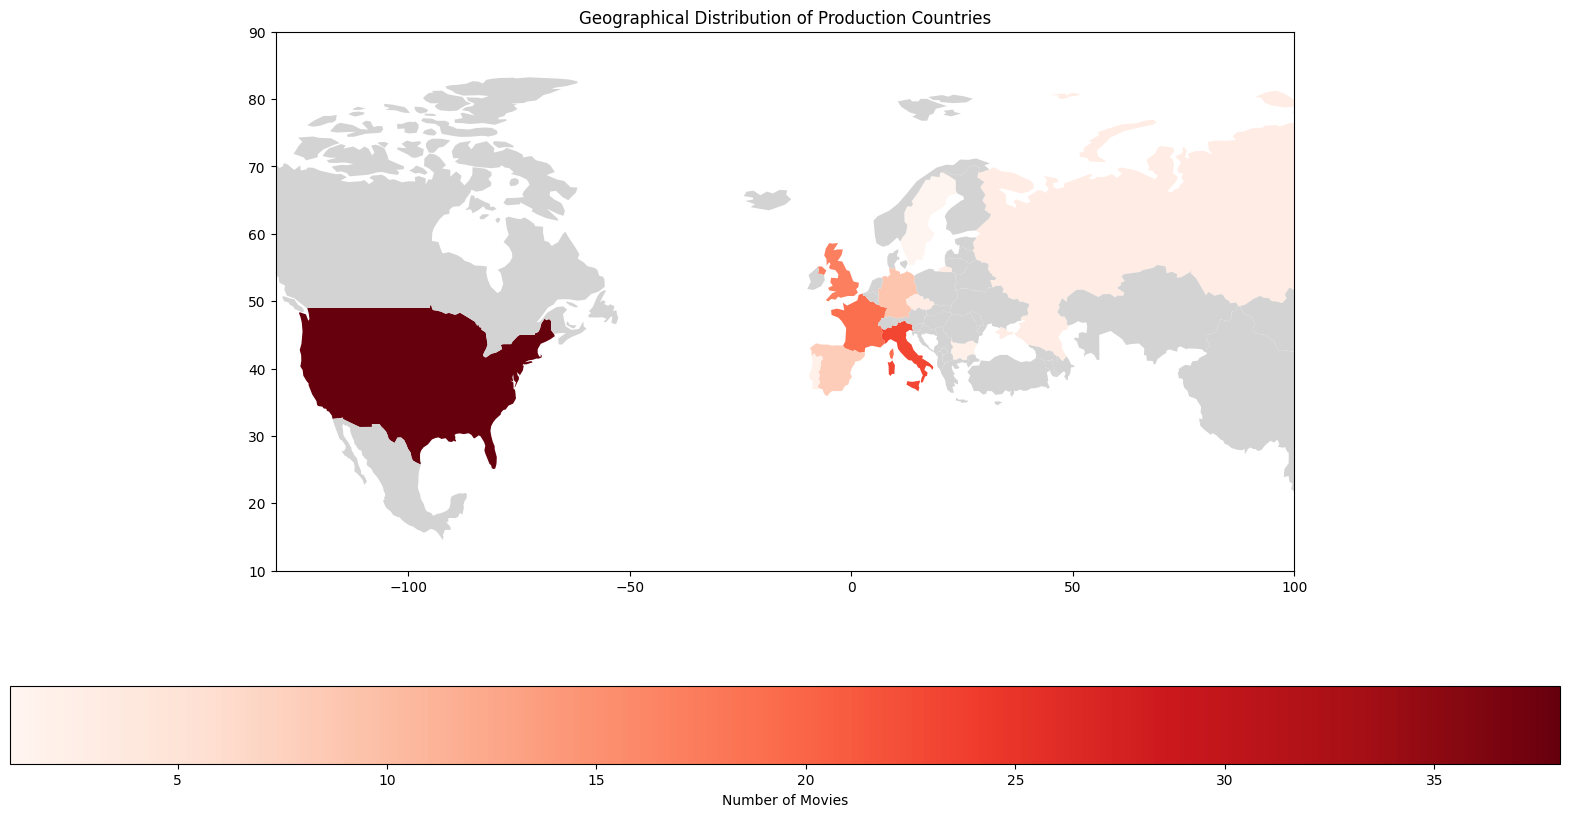

In [4]:
# Import an additional library for data visualization
import geopandas as gpd

# Normalize JSON data to a flat table
movies_df = pd.json_normalize(data['@graph'])

def extract_countries(country_list):
    if isinstance(country_list, list):
        return [country.get('name', None) for country in country_list if country.get('name', None)]
    return []

movies_df['countryOfOrigin'] = movies_df['countryOfOrigin'].apply(extract_countries)
movies_df = movies_df.explode('countryOfOrigin')

country_mapping = {
    'Czechoslovakia': 'Czechia',
    'USSR': 'Russia',
    'USA': 'United States of America',
    'UK': 'United Kingdom'
}

movies_df['countryOfOrigin'] = movies_df['countryOfOrigin'].replace(country_mapping)

country_counts = movies_df['countryOfOrigin'].value_counts().reset_index()
country_counts.columns = ['countryOfOrigin', 'counts']

# Load world map data from an additional file
world = gpd.read_file("./world_map/ne_110m_admin_0_countries.shp")

if 'NAME' not in world.columns:
    raise ValueError("The 'NAME' field for country is not present in the loaded GeoDataFrame")

world = world.merge(country_counts, how='left', left_on='NAME', right_on='countryOfOrigin')

northern_hemisphere_countries = [
    'Albania', 'Andorra', 'Armenia', 'Austria', 'Azerbaijan', 'Belarus', 'Belgium', 'Bosnia and Herzegovina',
    'Bulgaria', 'Canada', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Estonia', 'Finland', 'France', 'Georgia',
    'Germany', 'United Kingdom', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy', 'Kazakhstan', 'Kosovo', 'Latvia',
    'Liechtenstein', 'Lithuania', 'Luxembourg', 'Malta', 'Moldova', 'Monaco', 'Montenegro', 'Netherlands',
    'North Macedonia', 'Norway', 'Poland', 'Portugal', 'Romania', 'Russia', 'San Marino', 'Serbia',
    'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Turkey', 'Ukraine', 'United Kingdom',
    'Vatican City', 'United States of America', 'Mexico', 'Japan', 'South Korea', 'China', 'Mongolia'
]

northern_hemisphere = world[world['NAME'].isin(northern_hemisphere_countries)]

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
northern_hemisphere.plot(column='counts', ax=ax, legend=True,
                         legend_kwds={'label': 'Number of Movies', 'orientation': 'horizontal'},
                         missing_kwds={'color': 'lightgrey'},
                         cmap='Reds')

ax.set_xlim(-130, 100)
ax.set_ylim(10, 90)

ax.set_title('Geographical Distribution of Production Countries')
plt.show()

### Geospartial Analysis of Countries Depicted in Films

It's almost the same *map* as the previous one, but it shows the European countries where the films in the database are set.

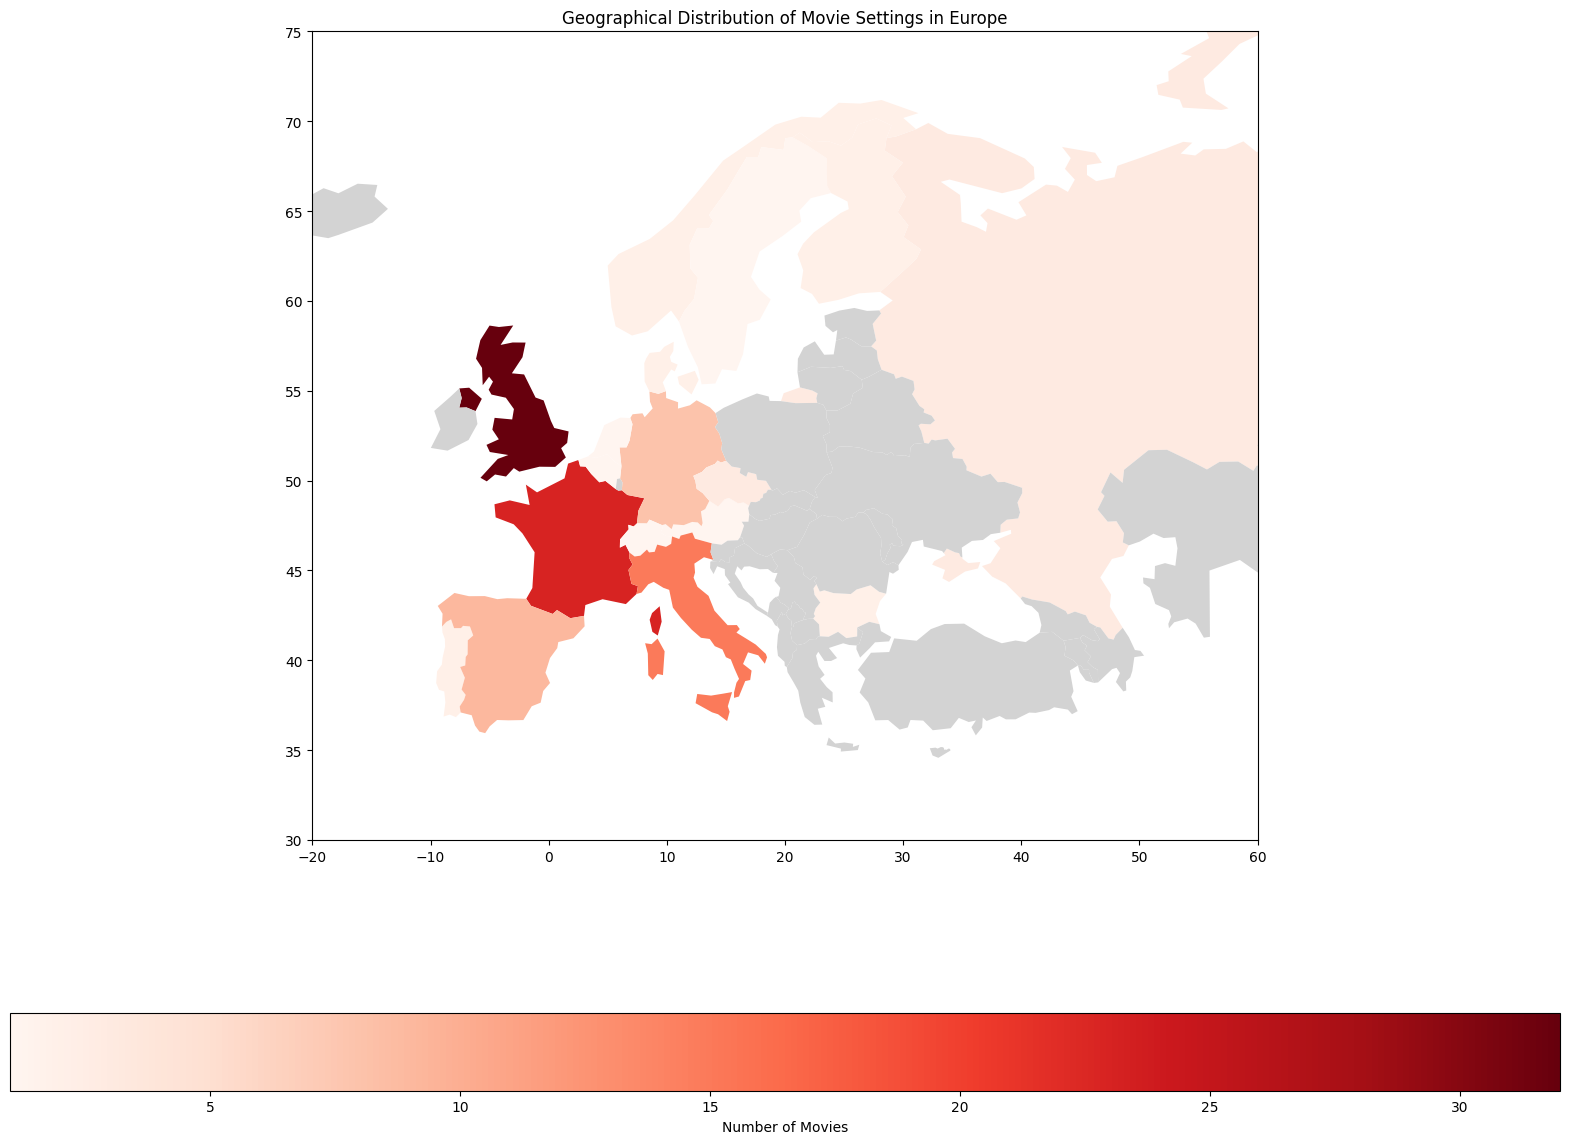

In [5]:
movies_df = pd.json_normalize(data['@graph'])

def extract_spatial_coverage(spatial_list):
    result = []
    if isinstance(spatial_list, list):
        for spatial in spatial_list:
            country_name = spatial.get('name', None) if isinstance(spatial, dict) else spatial
            if country_name:
                if country_name == 'Scandinavia':
                    result.extend(['Norway', 'Finland', 'Denmark'])
                else:
                    result.append(country_name)
    elif isinstance(spatial_list, str):
        if spatial_list == 'Scandinavia':
            result.extend(['Norway', 'Finland', 'Denmark'])
        else:
            result.append(spatial_list)
    return result

movies_df['spatialCoverage'] = movies_df['spatialCoverage'].apply(extract_spatial_coverage)
movies_df = movies_df.explode('spatialCoverage')

country_mapping = {
    'Czech Republic': 'Czechia',
    'Kievan Rus\'': 'Russia',
    'England': 'United Kingdom'
}

movies_df['spatialCoverage'] = movies_df['spatialCoverage'].replace(country_mapping)

country_counts = movies_df['spatialCoverage'].value_counts().reset_index()
country_counts.columns = ['spatialCoverage', 'counts']

world = gpd.read_file("./world_map/ne_110m_admin_0_countries.shp")

if 'NAME' not in world.columns:
    raise ValueError("The 'NAME' field is not present in the loaded GeoDataFrame")

world = world.merge(country_counts, how='left', left_on='NAME', right_on='spatialCoverage')

northern_hemisphere_countries = [
    'Albania', 'Andorra', 'Armenia', 'Austria', 'Azerbaijan', 'Belarus', 'Belgium', 'Bosnia and Herzegovina',
    'Bulgaria', 'Canada', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Estonia', 'Finland', 'France', 'Georgia',
    'Germany', 'United Kingdom', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy', 'Kazakhstan', 'Kosovo', 'Latvia',
    'Liechtenstein', 'Lithuania', 'Luxembourg', 'Malta', 'Moldova', 'Monaco', 'Montenegro', 'Netherlands',
    'North Macedonia', 'Norway', 'Poland', 'Portugal', 'Romania', 'Russia', 'San Marino', 'Serbia',
    'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Turkey', 'Ukraine', 'United Kingdom',
    'Vatican City', 'United States of America', 'Mexico', 'Japan', 'South Korea', 'China', 'Mongolia'
]

northern_hemisphere = world[world['NAME'].isin(northern_hemisphere_countries)]

fig, ax = plt.subplots(1, 1, figsize=(20, 15))
northern_hemisphere.plot(column='counts', ax=ax, legend=True,
                         legend_kwds={'label': 'Number of Movies', 'orientation': 'horizontal'},
                         missing_kwds={'color': 'lightgrey'},
                         cmap='Reds')

ax.set_xlim(-20, 60)
ax.set_ylim(30, 75)

ax.set_title('Geographical Distribution of Movie Settings in Europe')
plt.show()

### Complex Multi-dimensional Analysis

This code creates a multi-dimensional *scatter plot* visualizing the following film data:
- it iterates through unique genres, creating a scatter plot for each,
- it allows for the simultaneous analysis of release years, historical periods, and genres.
Different point sizes indicates film counts.

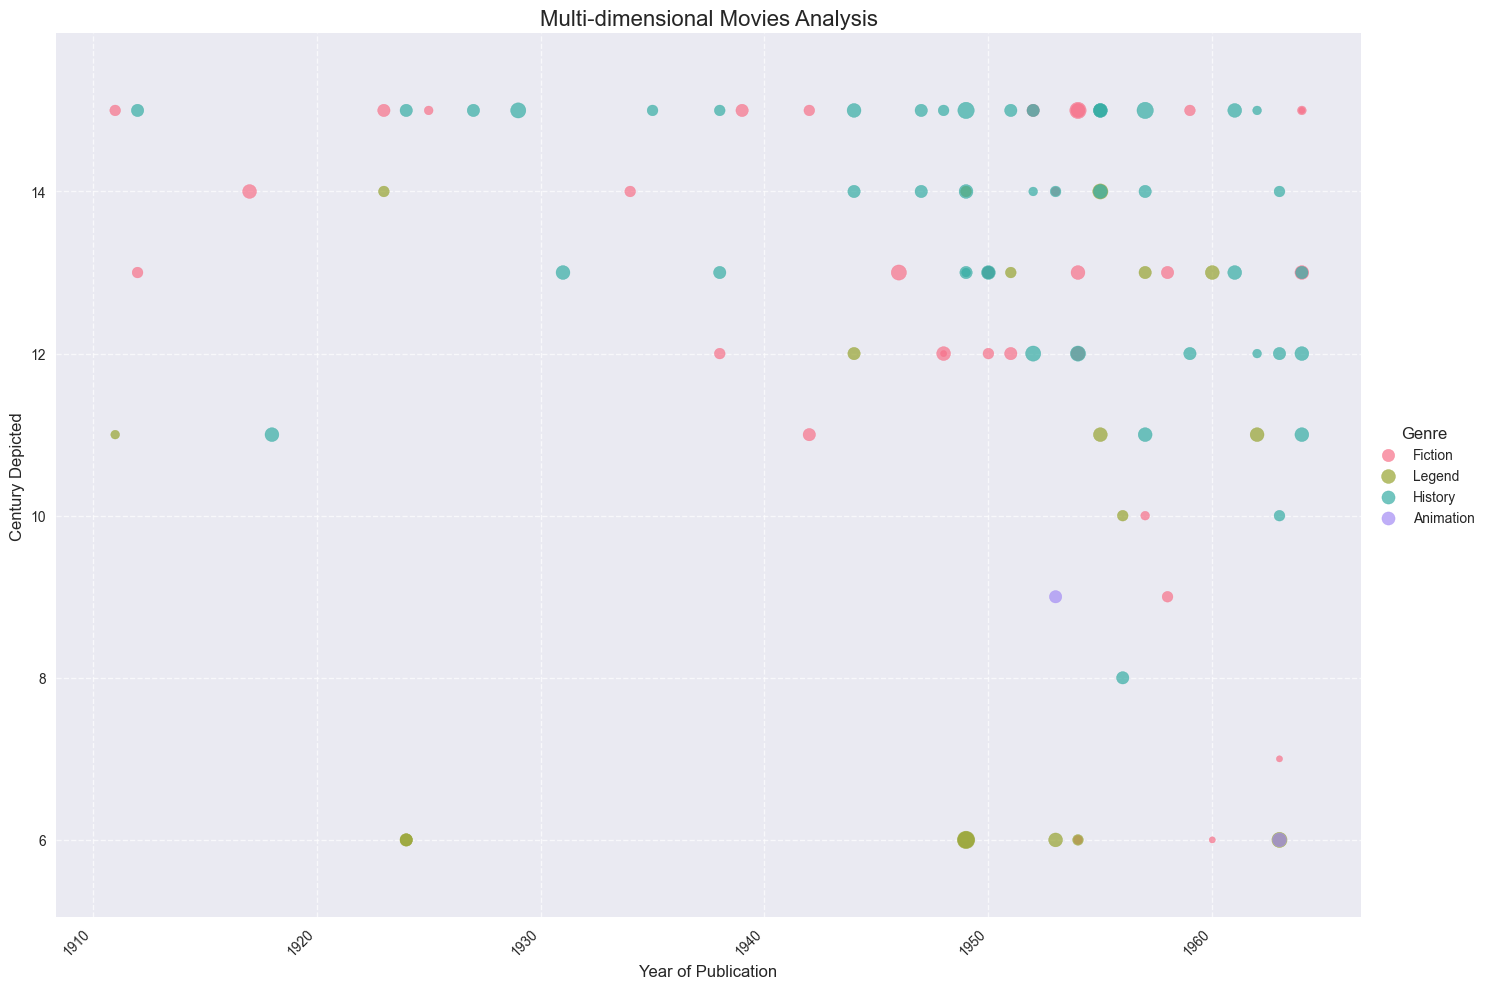

In [6]:
# Set the style for a cleaner look
plt.style.use('seaborn-v0_8')

fig, ax = plt.subplots(figsize=(15, 10))

df_exploded = df.explode('genre')

unique_genres = df_exploded['genre'].unique()

custom_palette = sns.color_palette("husl", n_colors=len(unique_genres))

color_dict = dict(zip(unique_genres, custom_palette))

for genre in unique_genres:
    genre_df = df_exploded[df_exploded['genre'] == genre]
    ax.scatter(
        genre_df['datePublished'],
        genre_df['century'],
        s=genre_df['keywords'].str.len()*20,
        c=[color_dict[genre]],
        alpha=0.7,
        label=genre
    )

ax.set_xlabel('Year of Publication', fontsize=12)
ax.set_ylabel('Century Depicted', fontsize=12)
ax.set_title('Multi-dimensional Movies Analysis', fontsize=16)

ax.legend(title='Genre', title_fontsize='12', fontsize='10', loc='center left', bbox_to_anchor=(1, 0.5))

ax.grid(True, linestyle='--', alpha=0.7)
y_min, y_max = ax.get_ylim()
ax.set_ylim(y_min - 0.5, y_max + 0.5)

plt.xticks(rotation=45, ha='right')

plt.tight_layout()

plt.show()

### Word Cloud

This is a *word cloud* of all the keywords from the database. It uses two additional libraries:
- Counter is for counting occurrences of keywords,
- WordCloud is for generating the word cloud.

It is a simple visualization: larger words represent more frequently occurring keywords.

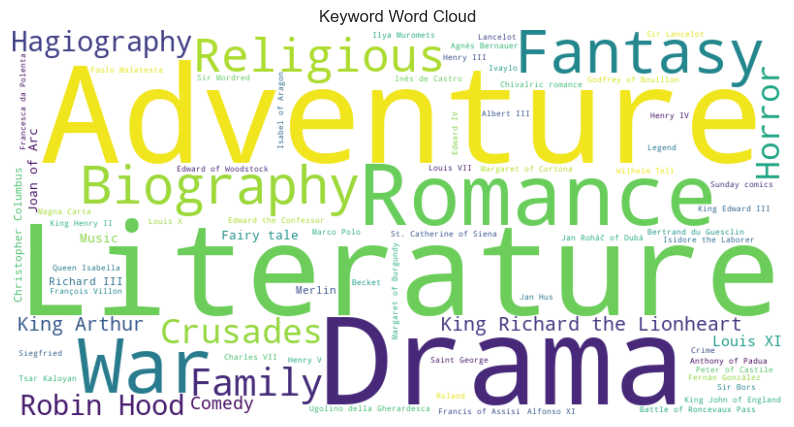

In [7]:
# Import additional libraries for data visualization
from collections import Counter
from wordcloud import WordCloud

keywords = []
for item in data['@graph']:
    if 'keywords' in item:
        keywords.extend(item['keywords'])

keyword_counts = Counter(keywords)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(keyword_counts)

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Keyword Word Cloud')
plt.show()

### Heatmap

This code creates a *heatmap visualization* of the top 20 keywords from the database. This format allows for quick identification of trends and patterns in keywords across films' historical periods. Darker colors indicate popular themes.

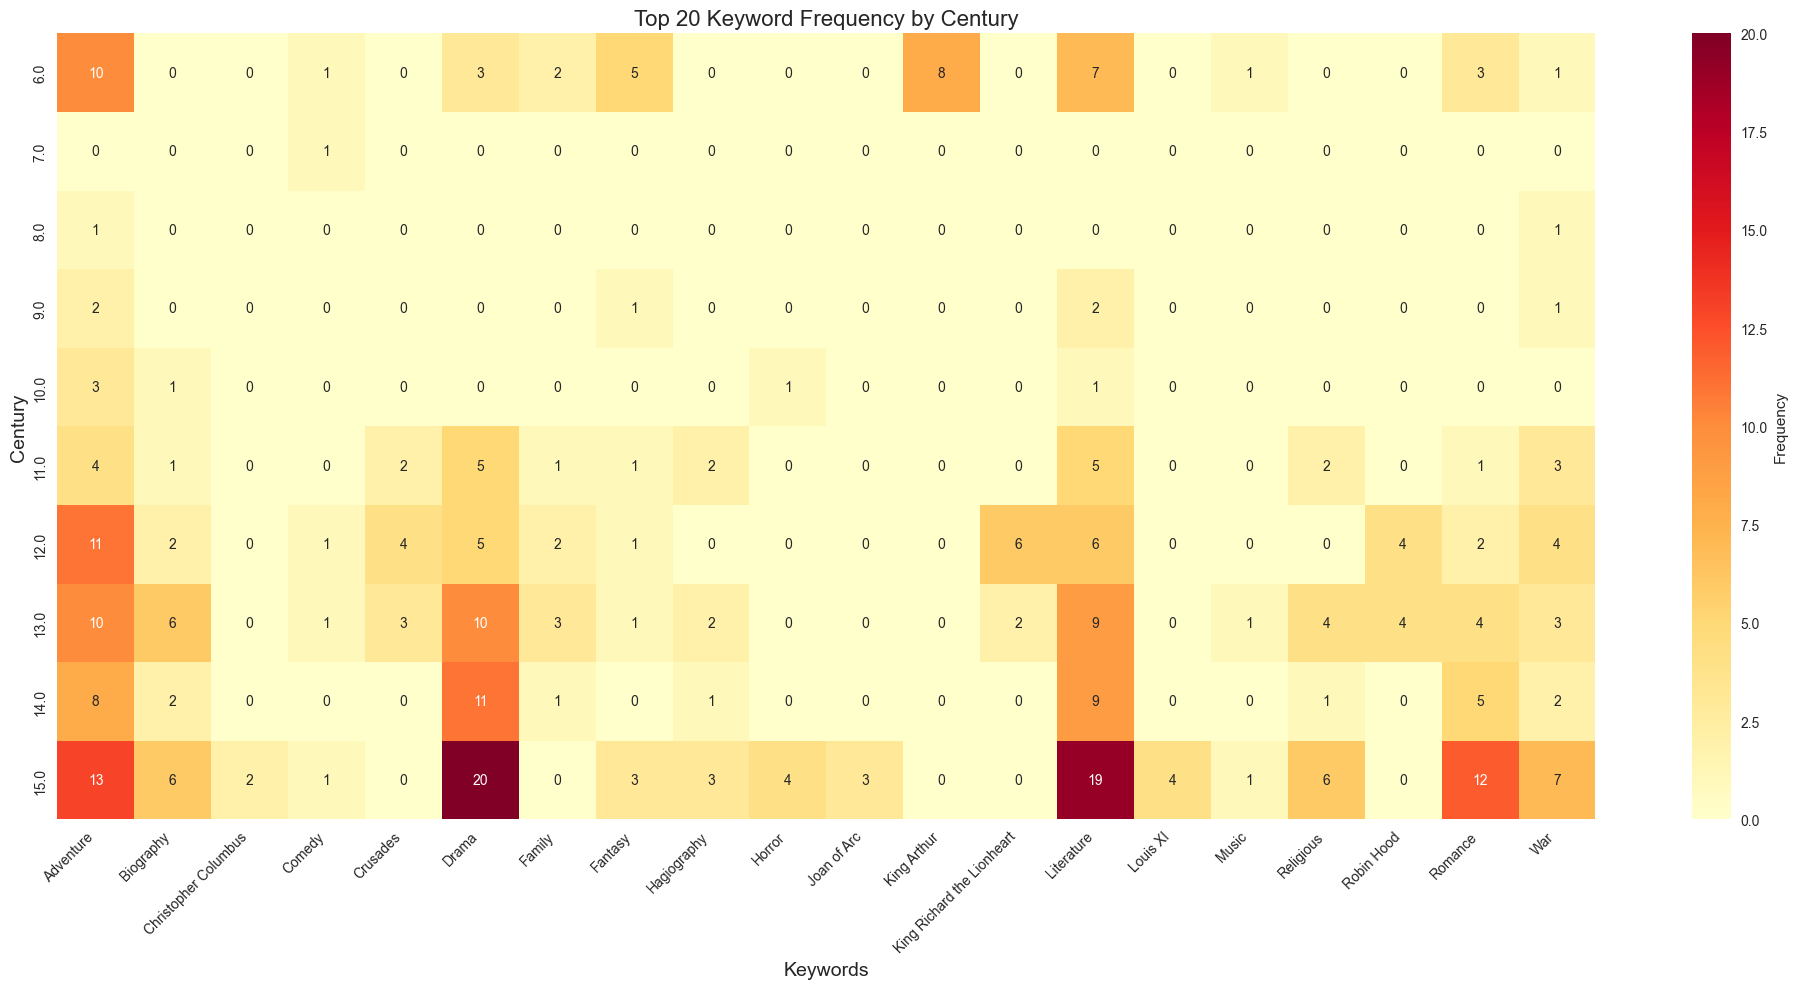

In [8]:
df_exploded = df.explode('keywords')

freq_table = df_exploded.groupby(['century', 'keywords']).size().reset_index(name='frequency')

top_20_keywords = freq_table.groupby('keywords')['frequency'].sum().nlargest(20).index
freq_table_top20 = freq_table[freq_table['keywords'].isin(top_20_keywords)]

pivot_top20 = freq_table_top20.pivot(index='century', columns='keywords', values='frequency').fillna(0)

plt.figure(figsize=(20, 10))
sns.heatmap(pivot_top20, cmap="YlOrRd", annot=True, fmt=".0f", cbar_kws={'label': 'Frequency'})
plt.title("Top 20 Keyword Frequency by Century", fontsize=16)
plt.xlabel("Keywords", fontsize=14)
plt.ylabel("Century", fontsize=14)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()

plt.show()

### Keywords Frequency

The following *bubble chart* provides the simultaneous visualization of four dimensions:
- periods,
- release years,
- keywords frequency,
- specific keywords.

This visualization reveals how the frequency of certain themes or keywords changes both in terms of the periods depicted and release years.

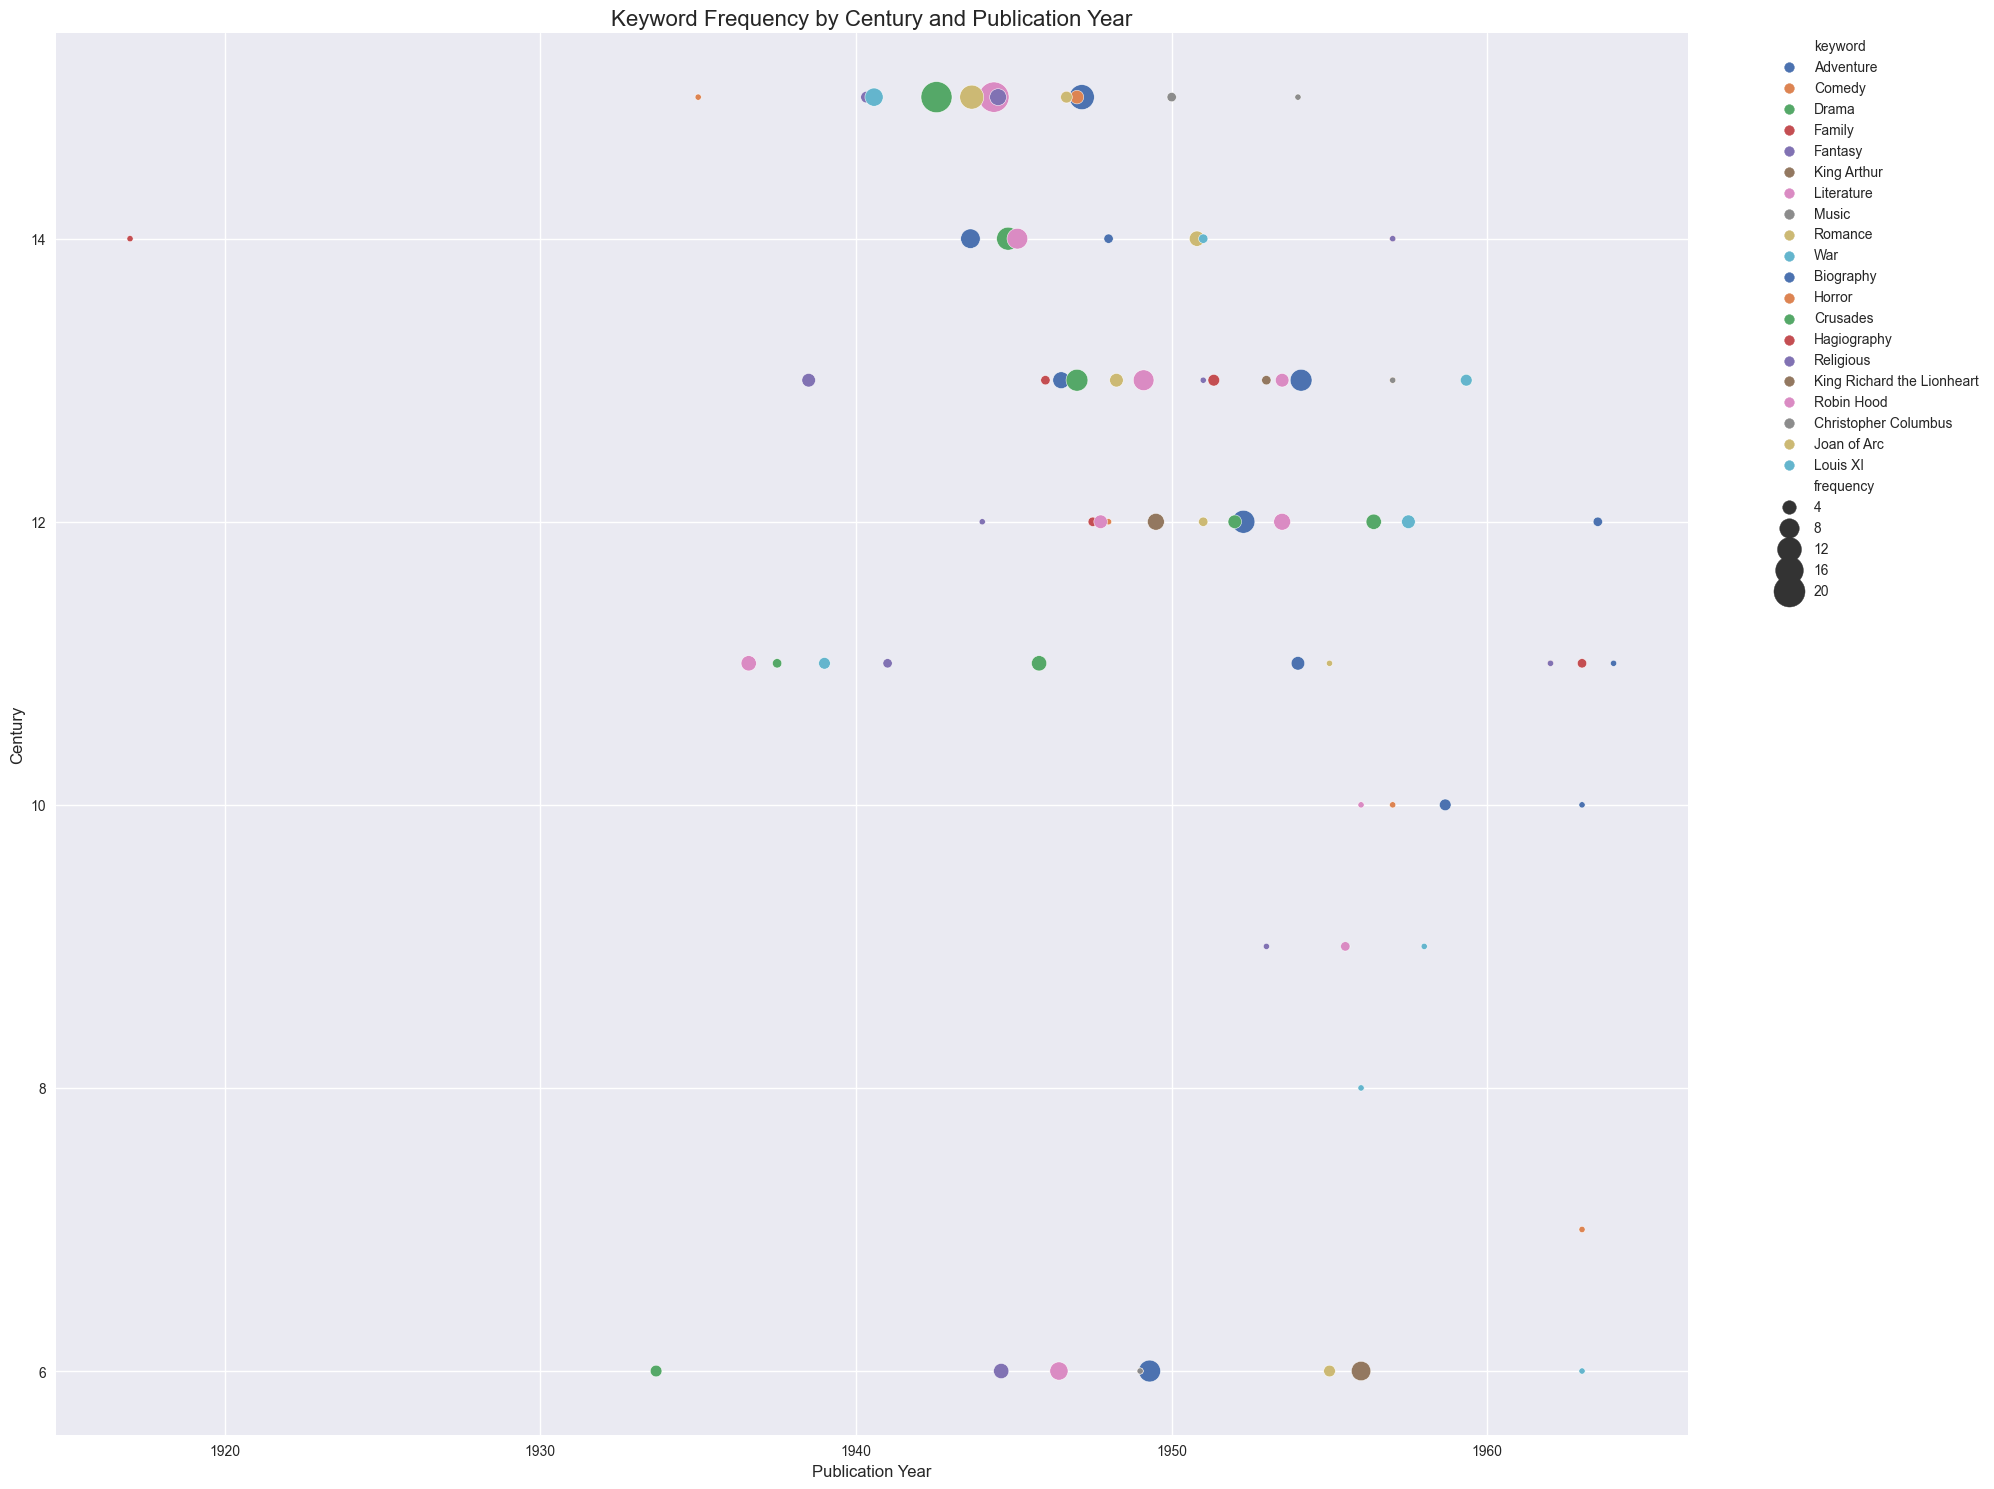

In [9]:
bubble_data = []
for century in pivot_top20.index:
    for keyword in pivot_top20.columns:
        freq = pivot_top20.loc[century, keyword]
        if freq > 0:
            avg_year = df_exploded[(df_exploded['century'] == century) & (df_exploded['keywords'] == keyword)]['datePublished'].mean()
            bubble_data.append({'century': century, 'keyword': keyword, 'frequency': freq, 'avg_year': avg_year})

bubble_df = pd.DataFrame(bubble_data)

plt.figure(figsize=(20, 15))
sns.scatterplot(data=bubble_df, x='avg_year', y='century', size='frequency', hue='keyword', palette='deep', sizes=(20, 500), legend='brief')
plt.title("Keyword Frequency by Century and Publication Year", fontsize=16)
plt.xlabel("Publication Year", fontsize=12)
plt.ylabel("Century", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.show()

### Evolution of Color and Sound 

These *charts* show:
- transition from black & white to color movies over time,
- adoption of sound in movies.

The *stacked area plot* for color illustrates the relative proportions of different color types, while the *line plot* for sound demonstrates the shift from silent to sound movies.

This type of analysis is valuable for understanding technological trends how they evolved over the first half of the 20th century.

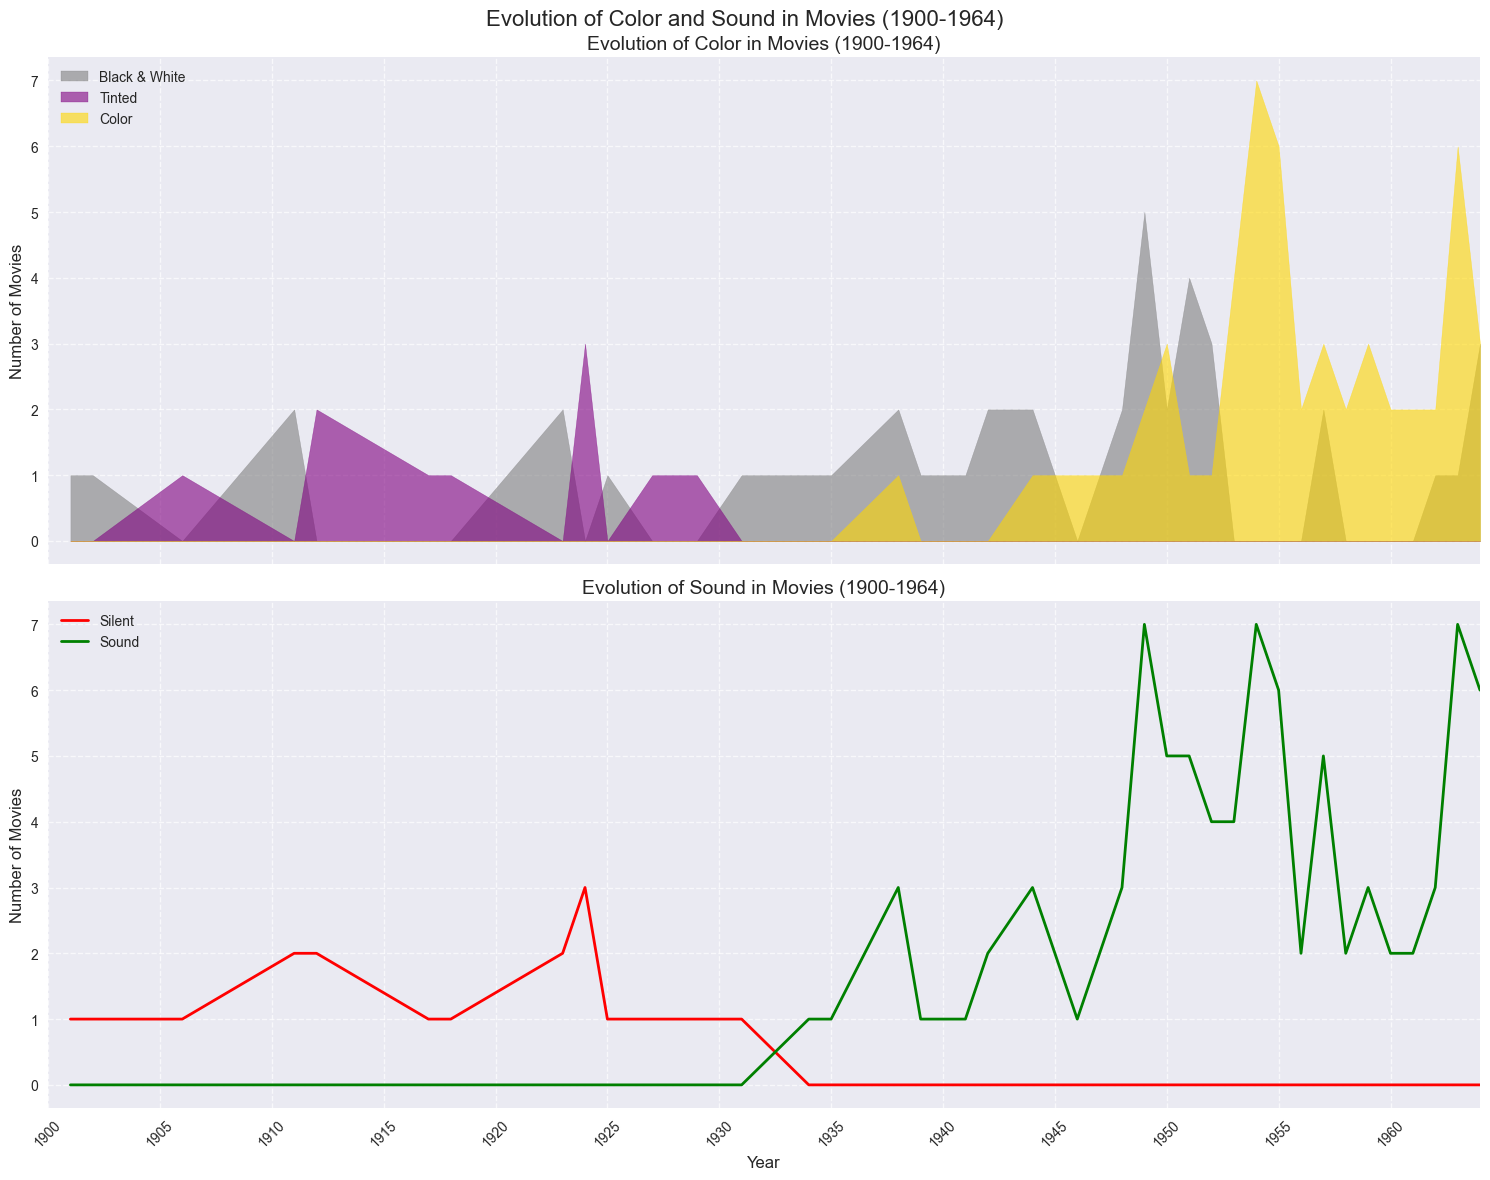

First year with color movies: 1938
First year with sound movies: 1934
Year when color movies surpassed B&W: 1946
Year when sound movies surpassed silent: 1934


In [10]:
movies = []
for movie in data['@graph']:
    color = 'Unknown'
    sound = False
    for prop in movie.get('additionalProperty', []):
        if prop['name'] == 'color':
            color = prop['value']
        elif prop['name'] == 'sound':
            sound = prop['value']

    movies.append({
        'name': movie['name'],
        'datePublished': movie['datePublished'],
        'color': color,
        'sound': sound
    })

df = pd.DataFrame(movies)

df['year'] = pd.to_datetime(df['datePublished']).dt.year
df['BW'] = (df['color'] == 'BW').astype(int)
df['Color'] = (df['color'] == 'C').astype(int)
df['Tinted'] = (df['color'] == 'Tint').astype(int)
df['Silent'] = (~df['sound']).astype(int)
df['Sound'] = df['sound'].astype(int)

yearly_data = df.groupby('year')[['BW', 'Color', 'Tinted', 'Silent', 'Sound']].sum()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

ax1.fill_between(yearly_data.index, yearly_data['BW'], label='Black & White', color='gray', alpha=0.6)
ax1.fill_between(yearly_data.index, yearly_data['Tinted'], label='Tinted', color='purple', alpha=0.6)
ax1.fill_between(yearly_data.index, yearly_data['Color'], label='Color', color='gold', alpha=0.6)
ax1.set_title('Evolution of Color in Movies (1900-1964)', fontsize=14)
ax1.set_ylabel('Number of Movies', fontsize=12)
ax1.legend(loc='upper left')

ax2.plot(yearly_data.index, yearly_data['Silent'], label='Silent', color='red', linewidth=2)
ax2.plot(yearly_data.index, yearly_data['Sound'], label='Sound', color='green', linewidth=2)
ax2.set_title('Evolution of Sound in Movies (1900-1964)', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Number of Movies', fontsize=12)
ax2.legend(loc='upper left')

plt.suptitle('Evolution of Color and Sound in Movies (1900-1964)', fontsize=16)
for ax in [ax1, ax2]:
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_xlim(1900, 1964)

plt.xticks(range(1900, 1965, 5), rotation=45)
plt.tight_layout()
plt.show()

print("First year with color movies:", yearly_data[yearly_data['Color'] > 0].index.min())
print("First year with sound movies:", yearly_data[yearly_data['Sound'] > 0].index.min())
print("Year when color movies surpassed B&W:", yearly_data[yearly_data['Color'] > yearly_data['BW']].index.min())
print("Year when sound movies surpassed silent:", yearly_data[yearly_data['Sound'] > yearly_data['Silent']].index.min())

### Keywords Over Time

The *line plot* tracks individual keyword trends while also facilitating comparison between keywords.

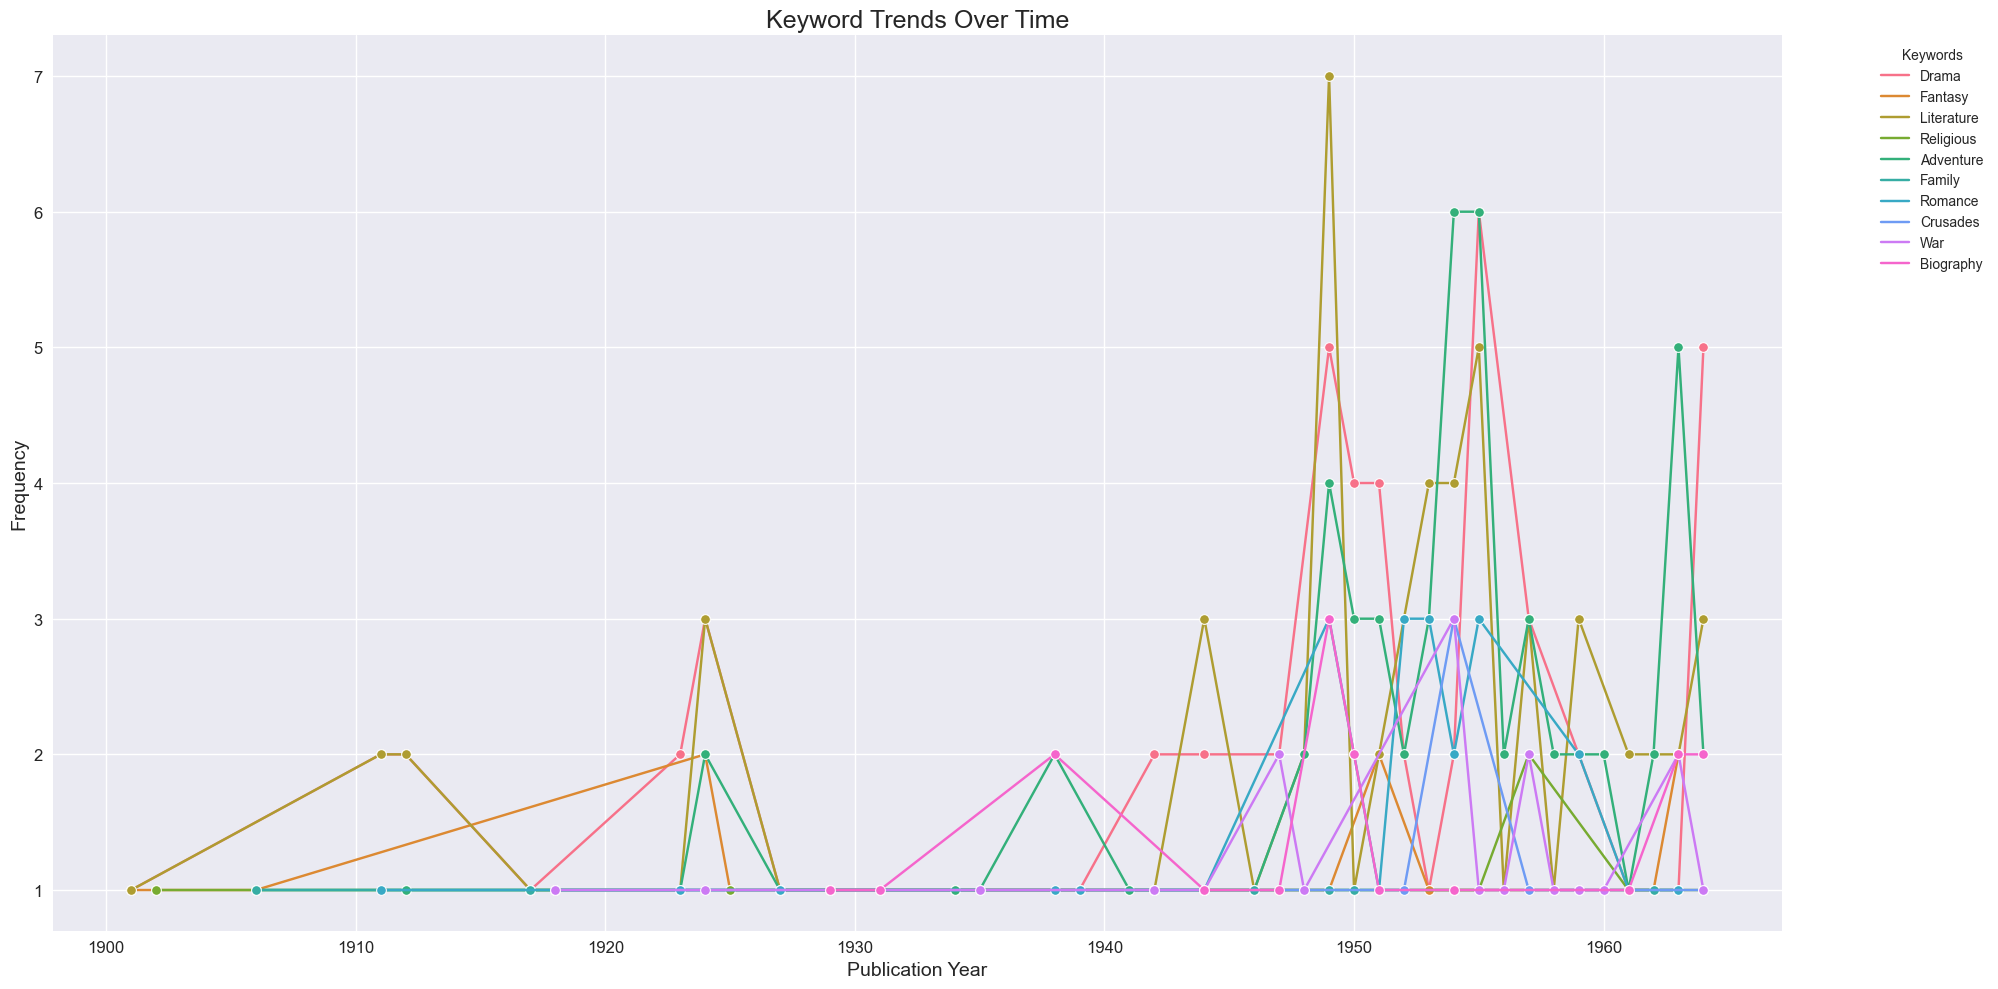

In [11]:
records = []

for item in data['@graph']:
    if 'keywords' in item and 'datePublished' in item:
        for keyword in item['keywords']:
            records.append({
                'datePublished': item['datePublished'],
                'keywords': keyword,
                'frequency': 1
            })

df = pd.DataFrame(records)

df['datePublished'] = pd.to_datetime(df['datePublished'], errors='coerce')
df['yearPublished'] = df['datePublished'].dt.year

df = df.dropna(subset=['yearPublished'])

trend_data = df.groupby(['yearPublished', 'keywords']).agg({'frequency': 'sum'}).reset_index()

top_keywords = trend_data.groupby('keywords')['frequency'].sum().nlargest(10).index

filtered_trend_data = trend_data[trend_data['keywords'].isin(top_keywords)]

plt.figure(figsize=(20, 10))
sns.lineplot(data=filtered_trend_data, x='yearPublished', y='frequency', hue='keywords', marker='o')

plt.title("Keyword Trends Over Time", fontsize=18)
plt.xlabel("Publication Year", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

plt.tick_params(axis='both', which='major', labelsize=12)

plt.legend(title='Keywords', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()